# Analyse Long Format Dataset

In [1]:
# assert project root is cwd
import os
os.chdir('../..')

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from src.d00_helpers import helpers as h
import seaborn as sns
from scipy.stats import ttest_ind
import numpy as np

In [4]:
# read in long dataframe

path_win='G://My Drive//Forschung//Mitarbeiter//Allgaier//23-12-06_Immun-ML//04_Data//01_processed//'
path_mac='/Users/johannesallgaier/My Drive/Forschung/Mitarbeiter/Allgaier/23-12-06_Immun-ML/04_Data/01_processed/'

name='2024.04.24_Mastertabelle'
df = pd.read_excel(path_win+f'{name}_long.xlsx',
                   parse_dates=['date'], index_col='Unnamed: 0', dtype={'vaccination': "Int64", 'infection':'Int64'})
df.rename(columns={'patient_id':'ID'}, inplace=True)

In [7]:
# read in baseline table to get demographic data
path_win='G://My Drive//Forschung//Mitarbeiter//Allgaier//23-12-06_Immun-ML//04_Data//00_raw//'
path_mac='/Users/johannesallgaier/My Drive/Forschung/Mitarbeiter/Allgaier/23-12-06_Immun-ML/04_Data/00_raw/'


bl = pd.read_excel(path_win+f'{name}.xlsx')
bl_sub=bl[['ID','Alter','Dialyse','Geschlecht']]

In [8]:
# Add information of Dialyse group
df = pd.merge(df, bl[['ID', 'Dialyse']], on='ID', how='left')

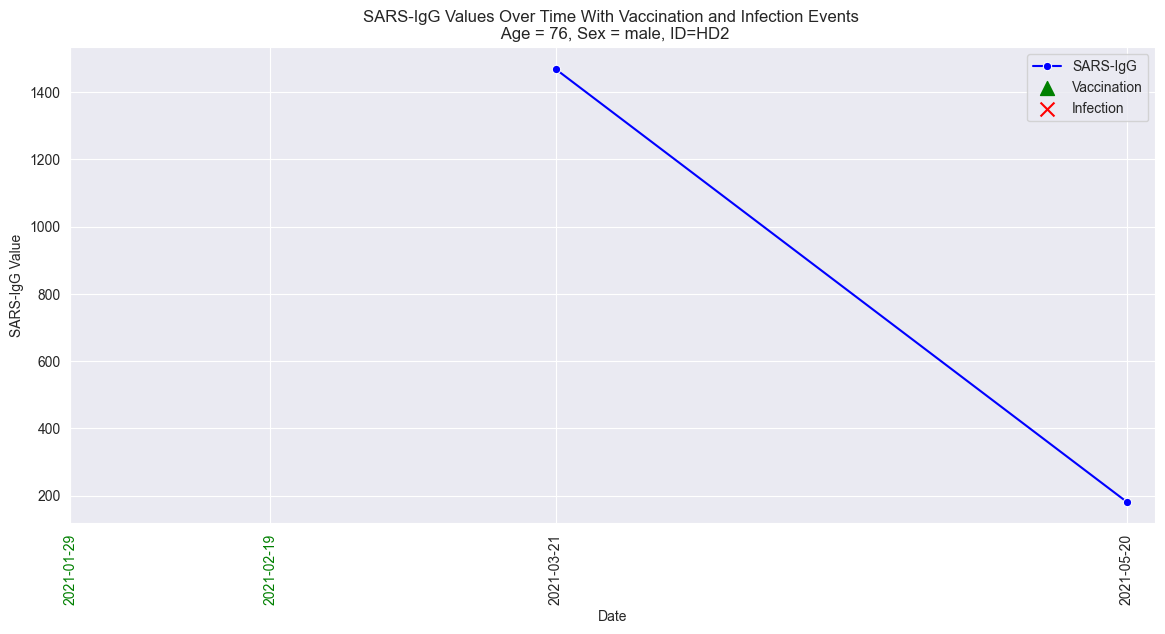

In [9]:
# loop over all patients and create single plots of their specific values
results_path = 'results/rq1/sars-igg-plots-by-patient'
for id in df.ID.unique()[:3]:
    bl_s = bl_sub[bl_sub['ID'] == id]
    df_s = df[df['ID'] == id]
    h.plot_sars_igg_with_events(df_s, results_path, bl_s, show_plot=True)

In [10]:
# reset index for easier mapping
bl = bl.set_index('ID')

# try to aggregate values and plot these on a time axis
vaccination_groups = dict(df.groupby(['ID'])['vaccination'].sum())
infection_groups = dict(df.groupby(['ID'])['infection'].sum())

In [11]:
# count number of vaccinations and infections
bl['n_vaccinations'] = None
for id in vaccination_groups.keys():
    bl.loc[id, 'n_vaccinations'] = vaccination_groups[id]

bl['n_infections'] = None
for id in infection_groups.keys():
    bl.loc[id, 'n_infections'] = infection_groups[id]

In [12]:
# merge this information into df
sub_df = pd.merge(df, bl[['n_vaccinations','n_infections']], how='left', left_on='ID', right_index=True)
# assign group ids
sub_df['group_id'] = sub_df.groupby(['Dialyse','n_vaccinations']).ngroup()

In [13]:
# sort by date and calculate n_vaccinations and n_infections until current date
sub_df = sub_df.sort_values(by='date')
sub_df['n_vaccinations_so_far'] = sub_df.groupby('ID')['vaccination'].cumsum()
sub_df['n_infections_so_far'] = sub_df.groupby('ID')['infection'].cumsum()

In [14]:
sub_df['event'] = sub_df['infection'] | sub_df['vaccination']

In [15]:
# Ensure the DataFrame is sorted by date
sub_df.sort_values(by='date', inplace=True)

# List to hold the DataFrame of each user after applying the function
dfs = []

# Group by user_id and apply the function to each group
for _, group in sub_df.groupby('ID'):
    group_result = h.calculate_days_since_last_event(group, event_col='event')
    dfs.append(group_result)

# Concatenate all the individual user DataFrames into a single DataFrame
result_df = pd.concat(dfs, ignore_index=True)

## What is the correlation of SARS-IgG and days sind last event?

In [16]:
sub_df = result_df[result_df['days_since_last_event'] != -1]
# remove outliers
sub_df = sub_df[sub_df['SARS-IgG']<15000]


sns.scatterplot(sub_df, y='SARS-IgG', x='days_since_last_event', hue='Dialyse')
plt.title('SARS-IgG values by days since last event (=vaccination or infection)')
plt.show()

## What is the average increase in SARS-IgG after an infection?

In [17]:
res_df = pd.DataFrame(columns=['ID', 'slope', 'sars_diff'])
for id in result_df['ID'].unique():

    sub_df = result_df[result_df['ID']==id]

    # timepoint where infection happened
    infection_dates = list(sub_df[sub_df['infection']==1]['date'])

    for infection_date in infection_dates:
        try:
            res = h.calc_average_sarsigg_increase(sub_df, infection_date)

            if res:
                res['ID'] = id
                res['Dialyse'] = sub_df.Dialyse.unique().tolist()[0]
                # Create a DataFrame for the row and use pd.concat to add it to res_df
                row_df = pd.DataFrame([res])  # Encapsulate 'res' in a list to treat it as a row
                res_df = pd.concat([res_df, row_df], ignore_index=True)
        except:
            pass

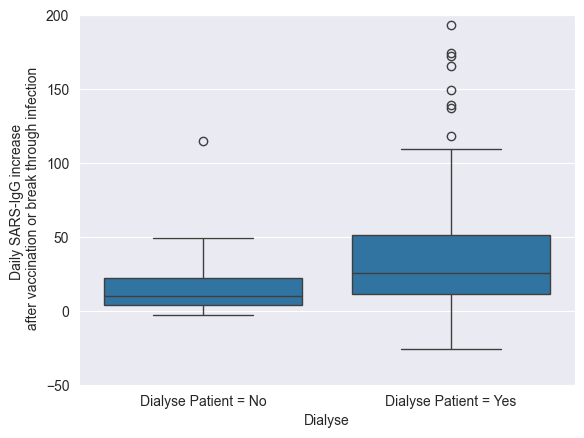

In [18]:
ax = sns.boxplot(res_df[res_df.slope<500], x='Dialyse', y='slope')

ax.set_ylim([-50, 200])

plt.ylabel('Daily SARS-IgG increase \n after vaccination or break through infection')
plt.xticks([0, 1], ['Dialyse Patient = No', 'Dialyse Patient = Yes'])


plt.show()

### Is the difference between dialyse and non-dialyse in SARS-IgG increase significant?


In [19]:


res_df[res_df['slope'] < 500]

dialyse = list(res_df[res_df['Dialyse'] == 1]['slope'])
non_dialyse = list(res_df[res_df['Dialyse'] == 0]['slope'])

ttest_ind(dialyse, non_dialyse, equal_var=False)

TtestResult(statistic=1.7046143510856324, pvalue=0.09288545689586086, df=67.208286452235)

Groups are not statistically significant from each other!

In [20]:
res_df

ID       slope  sars_diff  Dialyse
0    C10   -0.648667     -97.30      0.0
1   C114   18.664021    3620.82      0.0
2    C13   22.203778    1998.34      0.0
3   C132    9.744222     876.98      0.0
4   C137    3.597564     561.22      0.0
..   ...         ...        ...      ...
86  HD91   11.779091     518.28      1.0
87  HD92   19.776667    3559.80      1.0
88  HD94   36.733444    3306.01      1.0
89  HD97  139.438571    3904.28      1.0
90  HD98  -25.654000    -769.62      1.0

[91 rows x 4 columns]

## Check the distance in days between SARS-IgG measurements


In [21]:
# Ensure the date column is in datetime format
result_df['date'] = pd.to_datetime(result_df['date'])

# Sort the DataFrame by patient_id and date
result_df = result_df.sort_values(by=['ID', 'date'])

# Calculate the difference in days between the dates in consecutive rows for each patient
result_df['date_difference'] = result_df.groupby('ID')['date'].diff().dt.days

# Calculate the difference in days relative to the first measurement date for each patient
result_df['days_since_first_measurement'] = result_df.groupby('ID')['date'].transform(lambda x: (x - x.min()).dt.days)

In [22]:
pd.cut(result_df['days_since_first_measurement'], np.arange(0, 720, 30)).value_counts().sort_index()

days_since_first_measurement
(0, 30]       461
(30, 60]      245
(60, 90]       58
(90, 120]     188
(120, 150]     52
(150, 180]      9
(180, 210]    203
(210, 240]     81
(240, 270]    150
(270, 300]    138
(300, 330]    108
(330, 360]    145
(360, 390]    108
(390, 420]    126
(420, 450]    137
(450, 480]     36
(480, 510]     92
(510, 540]     57
(540, 570]     28
(570, 600]     85
(600, 630]     95
(630, 660]    127
(660, 690]     82
Name: count, dtype: int64

### What is the SARS-IgG course over the study?

In [23]:
# Setting the plot size
plt.figure(figsize=(14, 7))

# Create a custom color palette
# Assuming 'Dialyse' column has binary values 0 or 1
palette = {id: 'red' if result_df[result_df.ID==id].Dialyse.unique()[0] == 1 else 'blue'
           for id in result_df['ID'].unique()}

# Plotting SARS-IgG values over time
ax = sns.lineplot(data=result_df[result_df['SARS-IgG'] < 30000], x='date', y='SARS-IgG', hue='ID', style='group_id', palette=palette)

# Set the y-axis to log scale
ax.set_yscale("log")

plt.title('SARS-IgG course of healthy controls (blue) and dialyse patients (red)')

# Remove the legend
ax.legend_.remove()

# Show the plot
plt.show()

### For each group

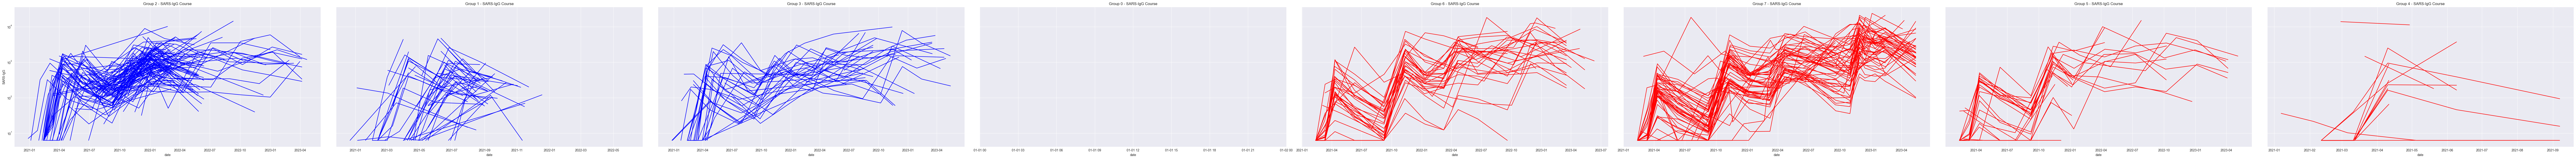

In [24]:
# Assuming 'result_df' is your DataFrame
group_ids = result_df['group_id'].unique()  # Get unique group IDs

# Setting the figure size appropriately
fig, axes = plt.subplots(nrows=1, ncols=len(group_ids), figsize=(14 * len(group_ids), 7), sharey=True)

# If only one group_id, axes might not be an array, handle this case
if len(group_ids) == 1:
    axes = [axes]

# Create a custom color palette based on 'Dialyse' column
palette = {id: 'red' if result_df[result_df.ID==id].Dialyse.unique()[0] == 1 else 'blue'
           for id in result_df['ID'].unique()}

# Iterate over each group_id and create a subplot
for ax, group_id in zip(axes, group_ids):

    # Filter the data for the current group_id
    group_data = result_df[(result_df['group_id'] == group_id) & (result_df['SARS-IgG'] < 30000)]

    # Plotting SARS-IgG values over time
    sns.lineplot(data=group_data, x='date', y='SARS-IgG', hue='ID', style='group_id', palette=palette, ax=ax)

    # Set the y-axis to log scale
    ax.set_yscale("log")

    # Set title for each subplot
    ax.set_title(f'Group {group_id} - SARS-IgG Course')

    # Remove the legend from each subplot to avoid clutter
    ax.legend_.remove()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

## Prepare dataset for ML

In [25]:
# Apply the function to each group
result_df['future_measurement_date'] = result_df.groupby('ID').apply(h.find_future_measurement_date).reset_index(level=0, drop=True)

In [26]:
def find_future_measurement(id, future_measurement_date):
    return result_df[(result_df['ID']==id) & (result_df['date']==future_measurement_date)]['SARS-IgG'].iloc[0]

idxs = result_df.dropna(subset='future_measurement_date').index

result_df['future_measurement_val'] = None

for idx in idxs:
    id = result_df.loc[idx, 'ID']
    future_measurement_date = result_df.loc[idx, 'future_measurement_date']
    result_df.loc[idx, 'future_measurement_val'] = find_future_measurement(id, future_measurement_date)



In [27]:
# convert 'date' format
result_df['date'] = result_df['date'].dt.strftime('%Y-%m-%d')

In [28]:
# get baseline information
result_df = pd.merge(result_df, bl[['Alter','Geschlecht','Dialyse']], left_on='ID', right_index=True, how='left')

In [29]:
# read in basline table to get demographic data
path = 'G://My Drive//Forschung//Mitarbeiter//Allgaier//23-12-06_Immun-ML//04_Data//03_ML//'
result_df.to_excel(path+f'{name}_ML.xlsx')